In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import nussl
from utils import viz, data
import yaml
import os

In [2]:
import json
from nussl.datasets import transforms as nussl_tfm
from pathlib import Path

In [3]:
from models.MaskInference import MaskInference
from models.UNet import UNetSpect
from models.Filterbank import Filterbank
from models.Waveform import Waveform

nussl.ml.register_module(MaskInference)
nussl.ml.register_module(UNetSpect)
nussl.ml.register_module(Filterbank)
nussl.ml.register_module(Waveform)

In [4]:
os.listdir('models/')

['.ipynb_checkpoints',
 'WaveUNet.py',
 '__pycache__',
 'MaskInference.py',
 'filterbank_default',
 'Waveform.py',
 'UNet.py',
 'Filterbank.py',
 'overfit',
 'mask_default',
 'Clustering.py',
 'VocalSepOnly']

In [5]:
model_name = 'overfit'
#model_name = 'filterbank_default'
#model_name = 'mask_default'

In [6]:
model_path = 'models/'+model_name+'/checkpoints/latest.model.pth'
config_path = 'models/'+model_name+'/configs.yml'
config_path = 'config/unet_default.yml'
#Optimizer checkpoints no longer stored
#optimizer_path = 'models/'+model_name+'/checkpoints/latest.optimizer.pth'

In [7]:
#Load yaml configs into configs dictionary
with open(config_path,'r') as f:
    configs = yaml.safe_load(f)
    f.close()

model_type = configs['model_type']
waveform_models = ['Filterbank','Waveform','WaveUNet']
if model_type in waveform_models:
    stft_params = None
    
    tfm = nussl_tfm.Compose([
        #nussl_tfm.SumSources([['bass', 'drums', 'other']]),
        nussl_tfm.GetAudio(),
        #nussl_tfm.IndexSources('source_audio', 1),
        nussl_tfm.ToSeparationModel(),
    ])
    
    # separator = nussl.separation.deep.DeepAudioEstimation(
    #     nussl.AudioSignal(), model_path=model_path,
    #     device='cpu',
    # )
    
    target_key = 'source_audio'
    output_key = 'audio'
    
else:
    stft_params = nussl.STFTParams(**configs['stft_params'])
    
    tfm = nussl_tfm.Compose([
        #nussl_tfm.SumSources([['bass', 'drums', 'other']]),
        nussl_tfm.MagnitudeSpectrumApproximation(),
        #nussl_tfm.IndexSources('source_magnitudes', 1),
        nussl_tfm.ToSeparationModel(),
    ])
    
    # separator = nussl.separation.deep.DeepMaskEstimation(
    #     nussl.AudioSignal(), model_path=model_path,
    #     device='cpu',
    # )
    
    target_key = 'source_magnitudes'
    output_key = 'estimates'

In [8]:
model_checkpoint = torch.load(model_path,map_location=torch.device('cpu'))
#Optimizer checkpoints no longer stored
#optimizer_checkpoint = torch.load(optimizer_path,map_location=torch.device('cpu'))

In [9]:
model_checkpoint['metadata']['trainer.state_dict']

{'epoch': 1,
 'epoch_length': 2,
 'max_epochs': 1,
 'output': {'loss': 0.0001715429243631661},
 'metrics': {'avg_loss': 0.0002876586065394804},
 'seed': None}

In [10]:
val_loss = model_checkpoint['metadata']['trainer.state.epoch_history']['validation/loss']
train_loss = model_checkpoint['metadata']['trainer.state.epoch_history']['train/loss']
n_epochs = model_checkpoint['metadata']['trainer.state_dict']['epoch']

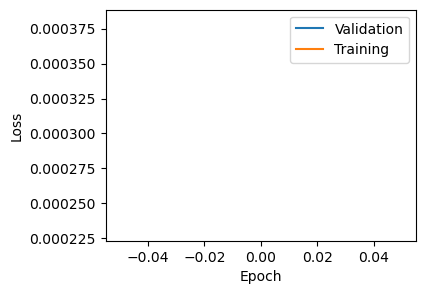

In [11]:
x = np.arange(n_epochs)
plt.figure(figsize=(4,3))
plt.plot(x,val_loss,label='Validation')
plt.plot(x,train_loss,label='Training')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

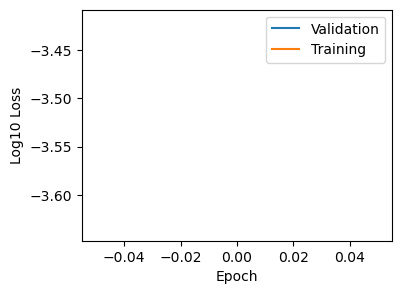

In [12]:
x = np.arange(n_epochs)
plt.figure(figsize=(4,3))
plt.plot(x,np.log10(val_loss),label='Validation')
plt.plot(x,np.log10(train_loss),label='Training')
plt.ylabel('Log10 Loss')
plt.xlabel('Epoch')
plt.legend()

In [13]:
from utils import data
#Test on the data
test_folder = configs['test_folder']
test_data = data.mixer(stft_params, transform=tfm, fg_path=configs['test_folder'], num_mixtures=50, coherent_prob=1.0, duration=5)
test_dataloader = torch.utils.data.DataLoader(test_data, num_workers=1, batch_size=1)

In [14]:
for i,batch in enumerate(test_dataloader):
    if i==1:
        batch=batch
        break
    
for key in batch:
    if torch.is_tensor(batch[key]):
        batch[key] = batch[key].float().to('cpu')   

In [ ]:
# self = separator.model.layers.model
# data = batch['mix_magnitude']
# output = separator.model(batch)

In [15]:
model = UNetSpect.build(num_sources=4, num_audio_channels=1, init_features=16, activation = 'sigmoid', logscale=True)

In [16]:
self = model.layers.model

In [18]:
num_sources=4

In [51]:
data = batch['mix_magnitude']

mix_magnitude = data

#Scale spectrograms to dB range (logscale)
#if self.logscale:
#    data = self.amplitude_to_db(data)

data = data.transpose(3, 1).transpose(2, 3)
data = data.tile(1,num_sources,1,1)

#Encoding convolutions down
down_conv1 = self.down_conv1(data)
down_conv1_max = self.max_pool(down_conv1)
down_conv2 = self.down_conv2(down_conv1_max)
down_conv2_max = self.max_pool(down_conv2)
down_conv3 = self.down_conv3(down_conv2_max)
down_conv3_max = self.max_pool(down_conv3)
down_conv4 = self.down_conv4(down_conv3_max)
down_conv4_max = self.max_pool(down_conv4)
down_conv5 = self.down_conv5(down_conv4_max)

#Decoding convolutions up
trans1 = self.transpose1(down_conv5)
up_conv1 = self.up_conv1(torch.cat([down_conv4, trans1], 1))
trans2 = self.transpose2(up_conv1)
up_conv2 = self.up_conv2(torch.cat([down_conv3, trans2], 1))
trans3 = self.transpose3(up_conv2)
up_conv3 = self.up_conv3(torch.cat([down_conv2, trans3], 1))
trans4 = self.transpose4(up_conv3)
up_conv4 = self.up_conv4(torch.cat([down_conv1, trans4], 1))

##Final convolution to calculate mask
out = self.out(up_conv4).transpose(3, 2).transpose(1, 3)

out = out.unsqueeze(-2)
out = out.tile(1,1,1,num_audio_channels,1)

In [50]:
num_audio_channels=1

In [52]:
out.shape

torch.Size([1, 432, 1024, 1, 4])

In [56]:
(mix_magnitude.unsqueeze(-1)*out).shape

torch.Size([1, 432, 1024, 1, 4])

In [ ]:
from nussl.ml.networks.modules import Embedding

In [44]:
test_embedding = Embedding(1024, 1024, 1,'sigmoid', 1)

In [45]:
mask = test_embedding(out)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (442368x4 and 1024x1024)

In [37]:
442368/4096

27.0

In [35]:
4096*4096

16777216

In [ ]:
self = separator.model.layers.model
data = batch['mix_magnitude']
output = separator.model(batch)
num_sources=4

mix_magnitude = data

#Scale spectrograms to dB range (logscale)
#if self.logscale:
#    data = self.amplitude_to_db(data)

data = data.transpose(3, 1).transpose(2, 3)
data = data.unsqueeze(0).tile(num_sources,1,1,1,1)

In [ ]:
data.shape

In [ ]:
tiled_data.shape

In [ ]:
import torch.nn as nn
final_conv = nn.Conv2d(self.features, 4, kernel_size=1)

In [ ]:
out = final_conv(up_conv4)

In [ ]:
out.shape

In [ ]:
#Final deconvolution
out = self.out(up_conv4).transpose(3, 2).transpose(1, 3).squeeze(-1)

In [ ]:
out = output[output_key].detach().numpy()
target = batch[target_key].detach().numpy()

In [ ]:
out.squeeze().T.shape

In [ ]:
target.squeeze().T

In [ ]:
if model_type in waveform_models:
    fig, axs = plt.subplots(2,2,figsize=(9,3))
    axs[0,0].plot(out.squeeze()[0,::100].T)
    axs[0,1].plot(out.squeeze()[1,::100].T)
    axs[1,0].plot(out.squeeze()[2,::100].T)
    axs[1,1].plot(out.squeeze()[3,::100].T)
else:
    fig, axs = plt.subplots(2,2,figsize=(9,3))
    axs[0,0].imshow(np.log(out.squeeze().T[0]+1e-16).T)
    axs[0,1].imshow(np.log(out.squeeze().T[1]+1e-16).T)
    axs[1,0].imshow(np.log(out.squeeze().T[2]+1e-16).T)
    axs[1,1].imshow(np.log(out.squeeze().T[3]+1e-16).T)

In [ ]:
if model_type in waveform_models:
    fig, axs = plt.subplots(2,2,figsize=(9,3))
    axs[0,0].plot(target.squeeze()[0,::100].T)
    axs[0,1].plot(target.squeeze()[1,::100].T)
    axs[1,0].plot(target.squeeze()[2,::100].T)
    axs[1,1].plot(target.squeeze()[3,::100].T)
else:
    fig, axs = plt.subplots(2,2,figsize=(9,3))
    axs[0,0].imshow(np.log(target.squeeze().T[0]+1e-16).T)
    axs[0,1].imshow(np.log(target.squeeze().T[1]+1e-16).T)
    axs[1,0].imshow(np.log(target.squeeze().T[2]+1e-16).T)
    axs[1,1].imshow(np.log(target.squeeze().T[3]+1e-16).T)

In [ ]:
np.mean((target-out)**2)

loss_fn = torch.nn.MSELoss()
loss_fn(torch.tensor(target),torch.tensor(out))

loss_fn = torch.nn.L1Loss()
loss_fn(torch.tensor(target),torch.tensor(out))

In [ ]:
from utils import data

#Test on the data
test_folder = configs['test_folder']
test_data = data.mixer(stft_params, transform=None, fg_path=configs['test_folder'], num_mixtures=50, coherent_prob=1.0, duration=5)

In [ ]:
item = test_data[1]
separator.audio_signal = item['mix']
estimates = separator()
viz.show_sources(estimates)